In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 25.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 88 kB/s 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.distances import CosineSimilarity


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        # indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

img_mean, img_std = (0.1307,), (0.3081,)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
)

batch_size = 64

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5


### pytorch-metric-learning stuff ###
# loss_func = losses.SupConLoss(temperature=0.1).to(device)
# loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
# accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###


distance = distances.CosineSimilarity()
loss_func = losses.SupConLoss(temperature=0.1, distance=distance).to(device)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Train the model

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 3.7503299713134766
Epoch 1 Iteration 100: Loss = 2.4609756469726562
Epoch 1 Iteration 200: Loss = 2.228257894515991
Epoch 1 Iteration 300: Loss = 2.1277780532836914
Epoch 1 Iteration 400: Loss = 1.9684498310089111
Epoch 1 Iteration 500: Loss = 2.282839298248291
Epoch 1 Iteration 600: Loss = 2.1967873573303223
Epoch 1 Iteration 700: Loss = 1.8732578754425049
Epoch 1 Iteration 800: Loss = 2.0739364624023438
Epoch 1 Iteration 900: Loss = 1.8408775329589844


100%|██████████| 313/313 [00:02<00:00, 144.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9861000000000001
Epoch 2 Iteration 0: Loss = 1.9041308164596558
Epoch 2 Iteration 100: Loss = 2.028869390487671
Epoch 2 Iteration 200: Loss = 2.0085573196411133
Epoch 2 Iteration 300: Loss = 1.8415812253952026
Epoch 2 Iteration 400: Loss = 2.0147054195404053
Epoch 2 Iteration 500: Loss = 2.0492124557495117
Epoch 2 Iteration 600: Loss = 2.2004642486572266
Epoch 2 Iteration 700: Loss = 1.9309563636779785
Epoch 2 Iteration 800: Loss = 2.0382015705108643
Epoch 2 Iteration 900: Loss = 1.9788553714752197


100%|██████████| 313/313 [00:02<00:00, 146.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9881000000000001
Epoch 3 Iteration 0: Loss = 2.0124478340148926
Epoch 3 Iteration 100: Loss = 1.9329016208648682
Epoch 3 Iteration 200: Loss = 1.9258716106414795
Epoch 3 Iteration 300: Loss = 2.1121456623077393
Epoch 3 Iteration 400: Loss = 1.9971307516098022
Epoch 3 Iteration 500: Loss = 1.9270340204238892
Epoch 3 Iteration 600: Loss = 1.8916561603546143
Epoch 3 Iteration 700: Loss = 1.9296783208847046
Epoch 3 Iteration 800: Loss = 1.9282760620117188
Epoch 3 Iteration 900: Loss = 1.8700745105743408


100%|██████████| 313/313 [00:02<00:00, 142.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9896
Epoch 4 Iteration 0: Loss = 2.052794933319092
Epoch 4 Iteration 100: Loss = 2.1004796028137207
Epoch 4 Iteration 200: Loss = 1.9195258617401123
Epoch 4 Iteration 300: Loss = 1.845895528793335
Epoch 4 Iteration 400: Loss = 1.849274754524231
Epoch 4 Iteration 500: Loss = 2.048781394958496
Epoch 4 Iteration 600: Loss = 1.8994317054748535
Epoch 4 Iteration 700: Loss = 1.855656385421753
Epoch 4 Iteration 800: Loss = 1.9707818031311035
Epoch 4 Iteration 900: Loss = 1.9492273330688477


100%|██████████| 313/313 [00:02<00:00, 138.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9888
Epoch 5 Iteration 0: Loss = 1.9476964473724365
Epoch 5 Iteration 100: Loss = 2.1295664310455322
Epoch 5 Iteration 200: Loss = 1.877427577972412
Epoch 5 Iteration 300: Loss = 1.8744550943374634
Epoch 5 Iteration 400: Loss = 1.825270652770996
Epoch 5 Iteration 500: Loss = 1.9146831035614014
Epoch 5 Iteration 600: Loss = 1.817598819732666
Epoch 5 Iteration 700: Loss = 1.926767110824585
Epoch 5 Iteration 800: Loss = 1.9570238590240479
Epoch 5 Iteration 900: Loss = 1.9704389572143555


100%|██████████| 313/313 [00:02<00:00, 140.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9902000000000001


# Evaluation

In [ ]:
test_embeddings, test_labels = get_all_embeddings(dataset2, model)
test_labels = test_labels.squeeze(1).cpu()

100%|██████████| 313/313 [00:02<00:00, 139.35it/s]


In [ ]:
n_vectors = test_embeddings.shape[0]
embedding_distances = distance(test_embeddings)

In [ ]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

In [ ]:
embedding_distances

tensor([[ 1.0000,  0.3519,  0.2579,  ...,  0.1114, -0.1164, -0.1857],
        [ 0.3519,  1.0000,  0.1242,  ...,  0.1499, -0.1769,  0.2265],
        [ 0.2579,  0.1242,  1.0000,  ...,  0.3863,  0.0064,  0.1650],
        ...,
        [ 0.1114,  0.1499,  0.3863,  ...,  1.0000,  0.0755,  0.2587],
        [-0.1164, -0.1769,  0.0064,  ...,  0.0755,  1.0000,  0.3860],
        [-0.1857,  0.2265,  0.1650,  ...,  0.2587,  0.3860,  1.0000]],
       device='cuda:0')

In [ ]:
cosine_distances = upper_tri_masking(embedding_distances)
cosine_distances = cosine_distances.cpu()

In [ ]:
xv, yv = np.meshgrid(test_labels, test_labels)
positiveness = (xv == yv).astype(int)
positiveness = upper_tri_masking(positiveness)

In [ ]:
positiveness, cosine_distances

(array([0, 0, 0, ..., 0, 0, 0]),
 tensor([0.3519, 0.2579, 0.0796,  ..., 0.0755, 0.2587, 0.3860]))

In [ ]:
positive_mask = positiveness == 1
positive_pair_distances = cosine_distances[positive_mask]
negative_pair_distances = cosine_distances[~positive_mask]

In [ ]:
positive_pair_distances.shape, negative_pair_distances.shape

(torch.Size([5012521]), torch.Size([44982479]))

# Histograms

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

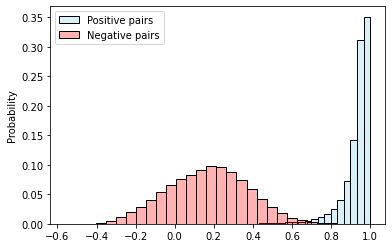

In [ ]:
sns.histplot(positive_pair_distances, color="skyblue", bins=30, label="Positive pairs", stat='probability', alpha=0.3)
sns.histplot(negative_pair_distances, color="red", bins=30, label="Negative pairs", stat='probability', alpha=0.3)

plt.legend() 
plt.show()

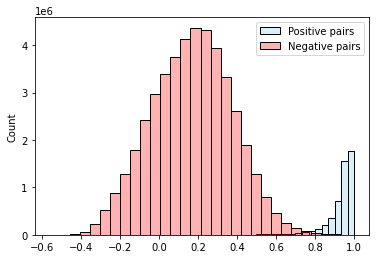

In [ ]:
sns.histplot(positive_pair_distances, color="skyblue", bins=30, label="Positive pairs", stat='count', alpha=0.3)
sns.histplot(negative_pair_distances, color="red", bins=30, label="Negative pairs", stat='count', alpha=0.3)

plt.legend() 
plt.show()

# Detection Error Trade (DET) curve

In [ ]:
from sklearn.metrics import det_curve, DetCurveDisplay

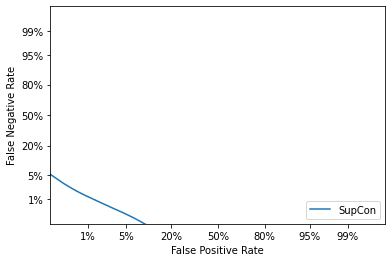

In [ ]:
positiveness[positiveness == 0] = -1
fpr, fnr, thresholds = det_curve(positiveness, cosine_distances)
display = DetCurveDisplay(
    fpr=fpr, fnr=fnr, estimator_name="SupCon"
)
display.plot()

plt.show()

# False Match Rate and False Non-Match Rate

In [ ]:
distance_thrs = np.linspace(cosine_distances.min(), cosine_distances.max(), num=200)
false_matches = np.zeros(distance_thrs.shape[0])
false_non_matches = np.zeros(distance_thrs.shape[0])

for i, thr in enumerate(tqdm(distance_thrs)):
    false_matches[i] = (negative_pair_distances > thr).sum()
    false_non_matches[i] = (positive_pair_distances < thr).sum()

  0%|          | 0/200 [00:00<?, ?it/s]

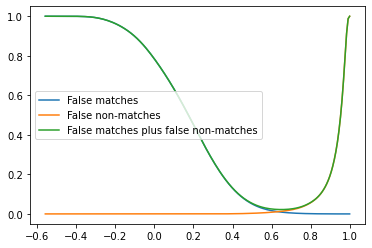

In [ ]:
sns.lineplot(x=distance_thrs, y=false_matches/negative_pair_distances.shape[0], label="False matches")
sns.lineplot(x=distance_thrs, y=false_non_matches/positive_pair_distances.shape[0], label="False non-matches")
sns.lineplot(x=distance_thrs, y=false_matches/negative_pair_distances.shape[0] + false_non_matches/positive_pair_distances.shape[0],
             label="False matches plus false non-matches")
plt.legend() 
plt.show()